In [2]:
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn import metrics
# Data wrangling 
import pandas as pd 
# Array math
import numpy as np 
# Quick value count calculator
from collections import Counter

In [3]:
# credits to Eligijus Bujokas
# Data wrangling 
import pandas as pd 

# Array math
import numpy as np 

# Quick value count calculator
from collections import Counter

def filter_zeroes(input_list):
    filtered_list = []
    for inner_list in input_list:
        create_set = set(inner_list)
        if len(create_set) == 1 and create_set.pop() == 0:
            continue
        filtered_list.append(inner_list)
    return filtered_list

class NodeRegression():
    """
    Class to grow a regression decision tree
    """
    
    def __init__(
        self, 
        Y: list,
        X: pd.DataFrame,
        matrix0:pd.DataFrame,
        rules_lists=None,
        residuals_lists=None,
        min_samples_split=None,
        max_depth=None,
        depth=None,
        node_type=None,
        rule=None,
        best_feature=None,
        best_value=None
    ):
        # Saving the data to the node 
        self.Y = Y 
        self.X = X
        self.matrix0 = matrix0
        # Saving the hyper parameters
        self.min_samples_split = min_samples_split if min_samples_split else 20    
        self.max_depth = max_depth if max_depth else 5

        # Default current depth of node 
        self.depth = depth if depth else 0

        # Extracting all the features
        self.features = list(self.X.columns)

        # Type of node 
        self.node_type = node_type if node_type else 'root'

        # Rule for spliting 
        self.rule = rule if rule else ""

        # Getting the mean of Y 
        self.ymean = np.mean(Y)

        # Getting the residuals 
        self.residuals = self.Y - self.ymean

        # Calculating the mse of the node 
        self.mse = self.get_mse(Y, self.ymean)

        # Saving the number of observations in the node 
        self.n = len(Y)
        self.good_indxs = self.X.index.tolist()
        self.rules_lists = rules_lists if rules_lists else [['j'] for i in range(self.n)]
        
        # Initiating the left and right nodes as empty nodes
        self.left = None 
        self.right = None 
        # Default values for splits
        self.best_feature =None 
        self.best_value =None 
        self.residuals_lists = residuals_lists if residuals_lists else [['j'] for i in range(self.n)]
        global n
        if self.node_type != 'root':
            for i in self.good_indxs:
                if i !=n:
                    self.rules_lists[i].append(self.rule)
                else:
                    self.rules_lists[i-1].append(self.rule)
            
    @staticmethod
    def get_mse(ytrue, yhat) -> float:
        """
        Method to calculate the mean squared error 
        """
        # Getting the total number of samples
        n = len(ytrue)

        # Getting the residuals 
        r = ytrue - yhat 

        # Squering the residuals 
        r = r ** 2

        # Suming 
        r = np.sum(r)

        # Getting the average and returning 
        return r / n

    @staticmethod
    def ma(x: np.array, window: int) -> np.array:
        """
        Calculates the moving average of the given list. 
        """
        return np.convolve(x, np.ones(window), 'valid') / window

    def best_split(self) -> tuple:
        """
        Given the X features and Y targets calculates the best split 
        for a decision tree
        """
        # Creating a dataset for spliting
        df = self.X.copy()
        df['Y'] = self.Y
        
        # Getting the GINI impurity for the base input 
        mse_base = self.mse

        # Finding which split yields the best GINI gain 
        #max_gain = 0

        # Default best feature and split
        best_feature = None
        best_value = None

        for feature in self.features:
            # Droping missing values
            Xdf = df.dropna().sort_values(feature)

            # Sorting the values and getting the rolling average
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                # Getting the left and right ys 
                left_y = Xdf[Xdf[feature]<value]['Y'].values
                right_y = Xdf[Xdf[feature]>=value]['Y'].values

                # Getting the means 
                left_mean = np.mean(left_y)
                right_mean = np.mean(right_y)

                # Getting the left and right residuals 
                res_left = left_y - left_mean 
                res_right = right_y - right_mean

                # Concatenating the residuals 
                r = np.concatenate((res_left, res_right), axis=None)

                # Calculating the mse 
                n = len(r)
                r = r ** 2
                r = np.sum(r)
                mse_split = r / n

                # Checking if this is the best split so far 
                if mse_split < mse_base:
                    best_feature = feature
                    best_value = value 

                    # Setting the best gain to the current one 
                    mse_base = mse_split

        return (best_feature, best_value)

    def grow_tree(self):
        """
        Recursive method to create the decision tree
        """
        # Making a df from the data 
        df = self.X.copy()
        df['Y'] = self.Y
        rules_lists = self.rules_lists
        

        # If there is GINI to be gained, we split further 
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):

            # Getting the best split 
            best_feature, best_value = self.best_split()

            if best_feature is not None:
                # Saving the best split to the current node 
                self.best_feature = best_feature
                self.best_value = best_value

                # Getting the left and right nodes
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy() 
                left_df2, right_df2 = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy() 
                good_left_indxs = left_df2.index.tolist()
                good_right_indxs = right_df2.index.tolist()
                lm = np.mean(left_df2['Y'].values.tolist())
                rm = np.mean(right_df2['Y'].values.tolist())
                for i in good_left_indxs:
                    left_df2['Y'][i] = round(lm, 8)
                for i in good_right_indxs:
                    right_df2['Y'][i] = round(rm, 8)
                global indxs
                for i in indxs:
                    if i in good_left_indxs:
                        matrix0.loc[i] = left_df2.loc[i]
                    if i in good_right_indxs:
                        matrix0.loc[i] = right_df2.loc[i]
                # Creating the left and right nodes
                left = NodeRegression(
                    left_df['Y'].values.tolist(), 
                    left_df[self.features], 
                    matrix0,
                    rules_lists,
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='left_node',
                    rule=f"x['{best_feature}'].iloc[i]<={round(best_value, 8)}"
                    )

                self.left = left 
                self.left.grow_tree()

                right = NodeRegression(
                    right_df['Y'].values.tolist(), 
                    right_df[self.features], 
                    matrix0,
                    rules_lists,
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='right_node',
                    rule=f"x['{best_feature}'].iloc[i]>{round(best_value, 8)}"
                    )

                self.right = right
                self.right.grow_tree()
                
    def fit(self, target) -> tuple:
        """
        Method for prediction of the residuals
        """ 
        indxs = range(self.n)
        max_depth_temp = self.max_depth
        min_samples_split_temp = self.min_samples_split
        # Growing the tree
        self.grow_tree()
        temp_matrix0 = matrix0.copy()  
        for i in indxs:
            matrix0['Y'].iloc[i] = d[target].iloc[i] - matrix0['Y'].iloc[i]     # residual at first step
        for i in range(self.n):
            if i !=n:
                self.residuals_lists[i].append(matrix0['Y'].iloc[i])
            else:
                self.residuals_lists[i-1].append(matrix0['Y'].iloc[i-1])
        #print('matrix0 on 0-th iteration after reduction\n', matrix0.sample(5, random_state = 7))
        temp_0 = matrix0['Y'].copy()
        temp_i=temp_0
        for j in range(10):
            root_i = NodeRegression(matrix0['Y'], X, matrix0, max_depth = max_depth_temp, min_samples_split = min_samples_split_temp)
            root_i.grow_tree()
            for i in range(self.n):  # matrix0['Y'].iloc[i] is now step_i that we must add to another: d['mpg'].iloc[i] -(matrix0['Y'].iloc[i] at step1) - (matrix0['Y'].iloc[i] at step2)
                if i !=n:
                    temp_matrix0['Y'].iloc[i] = temp_matrix0['Y'].iloc[i] + matrix0['Y'].iloc[i]
                    self.residuals_lists[i].append(matrix0['Y'].iloc[i])
                else:
                    self.residuals_lists[i-1].append(matrix0['Y'].iloc[i-1])
                    temp_matrix0['Y'].iloc[i-1] = temp_matrix0['Y'].iloc[i-1] + matrix0['Y'].iloc[i-1]
            #print('matrix0 on ',j,'-th iteration after fullfiling but before reduction\n', matrix0.sample(5, random_state = 7))
            for i in indxs:
                matrix0['Y'].iloc[i] = temp_i.iloc[i] - matrix0['Y'].iloc[i]
            #print('matrix0 on ',j,'-th iteration after reduction\n', matrix0.sample(5, random_state = 7))
            temp_i = matrix0['Y'].copy()
        
        #range1=(238,270,213,357,57)  #--- indexes from sample with random_state= 7
        #print('residuals\n')
        #for i in range(10):
        #    print(self.residuals_lists[i])
        #print('rules\n')
        #for i in range(10):
        #    print(self.rules_lists[i])
        
        #Adding rules_lists to temp_matrix0 as a column
        temp_matrix0['rules_lists'] = pd.Series(self.rules_lists) 
        
        self.matrix0 = temp_matrix0  ## здесь мы сохраняем матрицу matrix0 со столбцом ['Y'], преобразованным в этом методе
        
        # здесь мы оставляем у отдельного rules_lists только те строки, которые разные, необязательная часть
        #rules_lists = self.rules_lists
        #new_rl = []
        #for elem in rules_lists:
        #    if elem not in new_rl:
        #        new_rl.append(elem)
        #rules_lists = new_rl
        
        return (temp_matrix0)
    
    def predict(self, x) -> tuple:
        """
        Method for prediction of the Y_test from X_train trained on root-tree
        """
        # здесь мы оставляем у отдельного rules_lists только те строки, которые разные, необязательная часть
        new_rl = []
        rules_by_group = [[0] for i in range(len(self.rules_lists))]
        print(len(self.rules_lists))
        for idx, elem in enumerate(self.rules_lists):
            if elem not in new_rl:
                new_rl.append(elem) 
                rules_by_group[new_rl.index(elem)].append(idx)
            else:
                rules_by_group[new_rl.index(elem)].append(idx)
        rules_by_group = filter_zeroes(rules_by_group)
        y_pred = [[] for i in range(len(x))]
        # ниже если что я убрал matrix0 перед всеми rules_lists
        min_abs = 0
        for i in features: min_abs = min_abs + max(x[i])
        min_abs_idx = 0
        min_abs_temp = 0
        min_abs_temp = min_abs
        #if self.rules_lists.index(j) != len(self.rules_lists[k] - 1):
        for i in range(0,len(x)):                  
            for k in range(len(self.rules_lists)):
                for j in self.rules_lists[k]:
                    if eval(j) or j == 'j':
                        continue
                    else:
                        break
                else:                # здесь мы если всё хорошо, rule нам подходит
                    if i !=len(x):
                        #for s in range(len(rules_by_group)): print(rules_by_group[s])
                        min_abs = min_abs_temp
                        sum1 = 0
                        for m in rules_by_group[new_rl.index(self.rules_lists[k])]: 
                            for f in features: sum1 = sum1 + abs(x[f].iloc[i] - matrix0[f].iloc[m])
                            if  sum1 > min_abs:continue
                            else:
                                min_abs = 0
                                for f in features:
                                    min_abs = min_abs + abs(x[f].iloc[i] - matrix0[f].iloc[m])
                        else: 
                            min_abs_idx = m
                            print(min_abs_idx)
                            y_pred[i].append(self.matrix0.Y[min_abs_idx])
                    else:
                        min_abs = min_abs_temp
                        sum1=0
                        for m in rules_by_group[new_rl.index(self.rules_lists[k])]:
                            for f in features: sum1 = sum1 + abs(x[f].iloc[i-1] - matrix0[f].iloc[m])
                            if sum1 > min_abs:continue
                            else:
                                min_abs = 0
                                for f in features:
                                    min_abs = min_abs + abs(x[f].iloc[i-1] - matrix0[f].iloc[m])
                        else: 
                            min_abs_idx = m
                            print(min_abs_idx)
                            y_pred[i-1].append(self.matrix0.Y[min_abs_idx])
                    break
        return y_pred
    

    def print_info(self, width=4):
        """
        Method to print the infromation about the tree
        """
        # Defining the number of spaces 
        const = int(self.depth * width ** 1.5)
        spaces = "-" * const
        
        if self.node_type == 'root':
            print("Root")
        else:
            print(f"|{spaces} Split rule: {self.rule}")
            print(f"{' ' * const}   | MSE of the node: {round(self.mse, 8)}")
            print(f"{' ' * const}   | Count of observations in node: {self.n}")
            print(f"{' ' * const}   | Prediction of node: {round(self.ymean, 8)}")
            
        
    def print_tree(self):
        """
        Prints the whole tree from the current node to the bottom
        """
        self.print_info() 
        
        if self.left is not None: 
            self.left.print_tree()
        
        if self.right is not None:
            self.right.print_tree() 

Initial matrix0
 20     64540.0
2     106845.0
21     74009.0
62    147971.0
61    269297.0
Name: rise, dtype: float64


/tmp/ipykernel_1943/2541085053.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['rise'] = (d['rise']-min(d['rise']))/(max(d['rise'])-min(d['rise']))
/tmp/ipykernel_1943/1926391051.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df2['Y'][i] = round(lm, 8)
/tmp/ipykernel_1943/1926391051.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df2['Y'][i] = round

    Ключевая ставка  Ставка по вкладам в долларах до 1 года  StavkaVRub  \
20              8.3                                     2.9         5.5   
2               8.0                                     3.1         4.2   
21              8.3                                     3.0         5.8   
62             11.0                                     1.6         7.5   
61             11.0                                     1.6         7.7   

    Индекс потребительских цен, ед.  Курс доллара к рублю, руб  \
20                            115.7                         32   
2                             107.7                         28   
21                            116.3                         31   
62                            160.2                         70   
61                            159.5                         77   

    Номинальная средняя з/п, руб  month         Y  \
20                         25996      9  0.394481   
2                          22673      3  0.420

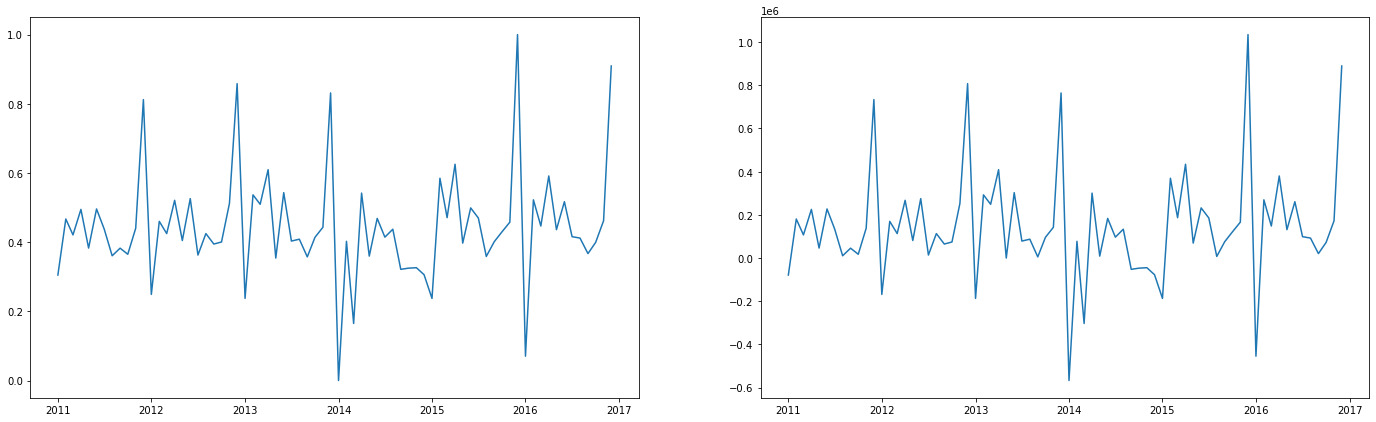

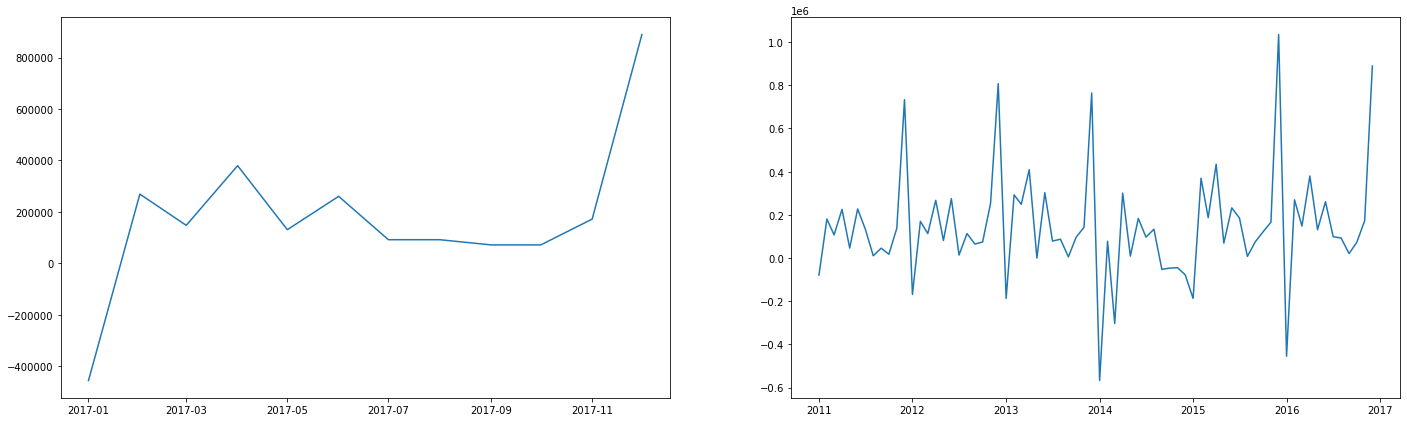

In [5]:
# credits for this part also to Eligijus Bujokas
col_names = ['date','rise','Доходность ОФЗ по сроку до 1 года','Ключевая ставка','Ставка по вкладам в долларах до 1 года','StavkaVRub','Нефть марки Юралс, долл./барр','Индекс потребительских цен, ед.','М0, руб','М2, руб','Курс доллара к рублю, руб','Номинальная средняя з/п, руб']
features = ['Ключевая ставка','Ставка по вкладам в долларах до 1 года','StavkaVRub','Индекс потребительских цен, ед.','Курс доллара к рублю, руб','Номинальная средняя з/п, руб']
# Reading data
d = pd.read_csv("/home/man/Desktop/fromdesk/bst_ds.csv",sep=';', header = 0, decimal=',', names=col_names, usecols=col_names)

df1 = pd.DataFrame(data=d)
df1['date'] = pd.to_datetime(df1['date'],format='%d.%m.%Y')
df1['month'] = df1['date'].dt.month
df1['year'] = df1['date'].dt.year
# Subsetting
d = df1[df1['rise'].notna()]   ## ---- there he removed rows, where values in column 'PUT_COLUMNNAME_HERE' were unknown, so be careful
# initial prediction 0
# Constructing the X and Y matrices
# Ensuring the correct types 
#for ft in features:
#    d[ft] = pd.to_numeric(d[ft])
# Constructing the X and Y matrices

X = d.drop(['date','rise','year','Доходность ОФЗ по сроку до 1 года','Нефть марки Юралс, долл./барр','М0, руб','М2, руб'],axis=1)    #   X := x_train
Y = d['rise']     #   Y := y_train

print('Initial matrix0\n', d.rise.sample(5, random_state = 7))

#Normalization
d['rise'] = (d['rise']-min(d['rise']))/(max(d['rise'])-min(d['rise']))
Y = (Y-min(Y))/(max(Y)-min(Y))

n = len(Y)
indxs = range(n)
X = X.reset_index(drop=True)   # ------ it needed for right displaying of indexes of dataframe  and operating with it
Y = Y.reset_index(drop=True)   # ------ it needed for right displaying of indexes of dataframe  and operating with it

test_d = df1[df1.rise.isnull()]
X_test = test_d.drop(['rise'],axis=1) 
X_test = X_test.drop(['date','year','Доходность ОФЗ по сроку до 1 года','Нефть марки Юралс, долл./барр','М0, руб','М2, руб'], axis = 1)
matrix0 = X.copy()
matrix0['Y'] = Y.copy()
#print(matrix0.iloc[:,2])      df.loc[row_indexer,column_indexer]
#print(matrix0.iloc[2,:])
target = 'rise'
# Initiating the Node
root = NodeRegression(Y, X, matrix0, max_depth=22, min_samples_split=5)
root.grow_tree()
trained_matrix = root.fit(target) # потом замени trained_matrix на trained_matrix['Y']
#Unnormilize back
#trained_matrix['Y'] = trained_matrix['Y']*(max(df1.rise)-min(df1.rise)) + min(df1.rise)
#d['rise'] = d['rise']*(max(df1.rise)-min(df1.rise)) + min(df1.rise)
print(trained_matrix.sample(5, random_state = 7))

#range1=(238,270,213,357,57)  #--- rindexes from sample with random_state= 7
#for i in range(len(rules_lists)):
#    print(rules_lists[i])
trained_matrix['date'] = d['date']
df1 = df1[df1['rise'].notna()]

x1 = [i for i in trained_matrix['date']]
y1 = [f for f in trained_matrix['Y']]
x2 = [i for i in df1['date']]
y2 = [f for f in df1['rise']]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 7))
axes[0].plot(x1, y1)
axes[1].plot(x2, y2)

Y_pred = root.predict(X_test) 
Y_pred = pd.DataFrame(Y_pred)
Y_pred = Y_pred.apply(pd.to_numeric, args=('coerce',))
#Unnormilize back
Y_pred = Y_pred*(max(df1.rise)-min(df1.rise)) + min(df1.rise)
#GRAPH
test_d = test_d.reset_index(drop=True)
test_d["rise"] = Y_pred
print(test_d["rise"])
x3 = [i for i in test_d['date']]
y3 = [f for f in test_d['rise']]
x4 = [i for i in df1['date']]
y4 = [f for f in df1['rise']]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 7))
axes[0].plot(x3, y3)
axes[1].plot(x4, y4)